## QA intent

Загрузим библиотеки и датасеты:

In [3]:
import annoy
from datasets import Dataset
import json
import pandas as pd
import torch
from torchinfo import summary
from transformers import AutoTokenizer, AutoModel

In [17]:
with open('./data/RuBQ_2.0_dev.json', 'r') as f:
    df = json.load(f)

In [18]:
with open('./data/RuBQ_2.0_test.json', 'r') as f:
    df_test = json.load(f)

Объединим оба датасета для обучения, т.к. даже суммарно они содержат всего  
менее 3 тыс. вопросов:

In [19]:
df.extend(df_test)

In [20]:
len(df)

2910

In [21]:
df = pd.DataFrame(df)[['question_text', 'answer_text']]

In [22]:
df.head()

,question_text,answer_text
0,Какой стране принадлежит знаменитый остров Пасхи?,Чили
1,С какой музыкальной группой неразрывно связано...,'Роллинг Стоунз'
2,Где находится Летний сад?,Санкт-Петербург
3,Какой город является столицей Туркмении?,Ашхабад
4,В каком городе издавалась с 1857 г. А. Герцено...,Лондон


Сохраним датасет для использования в дальнейшем в скрипте бота:

In [87]:
df.to_csv('./data/qa_data.csv', index=False)

Загрузим модель для создания эмбеддингов вопросов. За основу модели  
взята xlm-roberta-base.

In [23]:
model_name = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [79]:
summary(model)

Layer (type:depth-idx)                                  Param #
XLMRobertaModel                                         --
├─XLMRobertaEmbeddings: 1-1                             --
│    └─Embedding: 2-1                                   192,001,536
│    └─Embedding: 2-2                                   394,752
│    └─Embedding: 2-3                                   768
│    └─LayerNorm: 2-4                                   1,536
│    └─Dropout: 2-5                                     --
├─XLMRobertaEncoder: 1-2                                --
│    └─ModuleList: 2-6                                  --
│    │    └─XLMRobertaLayer: 3-1                        7,087,872
│    │    └─XLMRobertaLayer: 3-2                        7,087,872
│    │    └─XLMRobertaLayer: 3-3                        7,087,872
│    │    └─XLMRobertaLayer: 3-4                        7,087,872
│    │    └─XLMRobertaLayer: 3-5                        7,087,872
│    │    └─XLMRobertaLayer: 3-6                        7

In [24]:
model.cuda();

Напишем функцию для создания эмбеддингов предложений, в нашем  
случае вопросов. Используем для этого mean pooling:

In [56]:
def embed_sentence(sentence):
    
    text = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt').to(model.device)
    
    with torch.inference_mode():
        model_output = model(**text)
        
    token_embeddings = model_output[0]
    expanded_mask = text['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
    
    return (torch.sum(token_embeddings * expanded_mask, dim=1) / 
            torch.clamp(expanded_mask.sum(dim=1), min=1e-9)).squeeze()

Создадим и сохраним модель annoy для поиска ближайшего вопроса:

In [97]:
annoy_index = annoy.AnnoyIndex(model.config.hidden_size, 'angular')

for i, sentence in enumerate(df['question_text']):
    vector = embed_sentence(sentence)
    annoy_index.add_item(i, vector)

In [98]:
annoy_index.build(1000, n_jobs=-1)

True

In [99]:
annoy_index.save('./models/qa_annoy_model.ann')

True

## Chit-chat intent

Загрузим библиотеки и датасет:

In [1]:
import re
from transformers import (AutoModelForCausalLM,
                          DataCollatorForLanguageModeling,
                          TrainingArguments, Trainer)

In [4]:
df = pd.read_csv('./data/dialogues.tsv', sep='\t')

In [5]:
df['dialogue'].iloc[0]

'<span class=participant_2>Пользователь 2: Привет) расскажи о себе</span><br /><span class=participant_1>Пользователь 1: Привет) под вкусный кофеек настроение поболтать появилось<br />)</span><br /><span class=participant_2>Пользователь 2: Что читаешь? Мне нравится классика</span><br /><span class=participant_2>Пользователь 2: Я тоже люблю пообщаться</span><br /><span class=participant_1>Пользователь 1: Люблю животных, просто обожаю, как и свою работу)</span><br /><span class=participant_1>Пользователь 1: Я фантастику люблю</span><br /><span class=participant_2>Пользователь 2: А я выращиваю фиалки</span><br /><span class=participant_2>Пользователь 2: И веду здоровый и активный образ жизни!</span><br /><span class=participant_1>Пользователь 1: Ух ты, интересно.</span><br /><span class=participant_2>Пользователь 2: Ты случайно не принц на белом коне? Я его очень жду<br />..</span><br /><span class=participant_1>Пользователь 1: А у меня из хобби каждую неделю тусить с моим лучшим<br />дру

Предобработаем датасет. Уберём все html-блоки, добавим специальные  
токены. Вместо "Пользователь" будет спецтокен \[SEP\], если следующая  
реплика принадлежит другому пользователю:

In [5]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', ' ', text).strip()
    text = text.split()
    number = ''
    for i in range(len(text)):
        if text[i] == 'Пользователь':
            if text[i + 1] != number:
                text[i] = '[SEP]'
                number = text[i + 1]
                text[i + 1] = ''
            else:
                text[i - 1] += '.'
                text[i] = ''
                text[i + 1] = ''
    text = ' '.join(text)
    text = re.sub('\s+', ' ', text)
    text = text.replace('[SEP]', '[BOS]', 1) + ' [SEP]'
    return text

In [6]:
preprocess_text(df['dialogue'].iloc[5])

'[BOS] Привет! [SEP] Привет!. Как дела?) [SEP] У меня все замечательно. А твои дела как? Чем занимаешься по жизни?. ? [SEP] Рада новому знакомству! У меня тоже всё неплохо. Недавно нашла работу по специальности. Я дизайнер. А ты чем занимаешься?. Ты откуда? [SEP] Я продавец, выращиванию овощи и фрукты на даче и продаю их. Я ещё кстати и дачница.. Я с Украины ). А ты откуда ? [SEP] Круто! Я из Беларуси, Минск [SEP] Я продавец, выращиваю овощи и фрукты на даче и продаю их. Я ещё кстати и дачница.. Как зовут тебя ? [SEP] А я мечтаю купить дачу, но пока не могу себе этого позволить(. Катя, а тебя? [SEP] Ира,приятно познакомится ). А я мечтаю жить возле моря. [SEP] Кстати, была в Украине, мне там очень понравилось . Я вообще люблю путешествовать [SEP] Обожаю море. [SEP] Приятно познакомиться [SEP] В каком городе Украины ты была ? [SEP] О, я тоже люблю море)). Много где, и в Крыму (тогда это была ещё Украина) [SEP] Жду не дождусь лета, что бы поехать на море 🌊. К стати, ты любишь собак? [SEP

In [6]:
df = df['dialogue'].apply(preprocess_text)

In [7]:
df = Dataset.from_pandas(pd.DataFrame(df))

In [8]:
df

Dataset({
    features: ['dialogue'],
    num_rows: 10013
})

За основу возьмём маленькую версию модели ruGPT3 от Сбера:

In [11]:
model_name = 'sberbank-ai/rugpt3small_based_on_gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Добавим новые специальные токены в токенизатор и выровняем  
конфиг модели для работы с изменившимся размером словаря:

In [12]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>'}

In [13]:
new_special_tokens = {'bos_token': '[BOS]',
                      'pad_token': '[PAD]',
                      'sep_token': '[SEP]',
                      'unk_token': '[UNK]'}

In [14]:
tokenizer.add_special_tokens(new_special_tokens)

4

In [15]:
tokenizer.special_tokens_map

{'bos_token': '[BOS]',
 'eos_token': '<|endoftext|>',
 'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]'}

In [16]:
len(tokenizer)

50262

In [17]:
tokenizer.eos_token_id

50257

In [18]:
tokenizer.bos_token_id

50258

In [19]:
model.transformer.config.bos_token_id = 50258
model.transformer.config.eos_token_id = 50257

In [20]:
model.resize_token_embeddings(len(tokenizer))

Embedding(50262, 768)

Посмотрим на размер текстов в токенах:

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

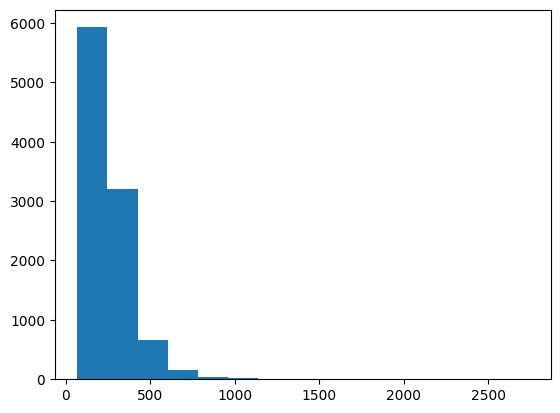

In [21]:
plt.hist([len(tokenizer.encode(x)) for x in df['dialogue']], bins=15);

За максимальную длину текстов в токенах выберем число 1024.  
Сделаем токенизацию текстов:

In [15]:
def tokenize_fn(text):
    return tokenizer(text['dialogue'], padding=True, truncation=True, max_length=1024, return_tensors='pt')

In [16]:
df = df.map(tokenize_fn, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

Сделаем необходимые приготовления и дообучим модель на  
нашем датасете:

In [17]:
df = df.remove_columns(['dialogue'])

In [18]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [22]:
training_args = TrainingArguments(
    output_dir='./models/gpt',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=1,
    # gradient_accumulation_steps=32,
    logging_strategy='epoch',
    report_to='none',
    seed=29,
    save_strategy='epoch'
)

PyTorch: setting up devices


In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=df,
    optimizers=(torch.optim.AdamW(model.parameters(), lr=2e-5), None)
)

In [20]:
trainer.train()

***** Running training *****
  Num examples = 10013
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 30039
  Number of trainable parameters = 125230080
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10013,3.059100
20026,2.812600
30039,2.694000


Saving model checkpoint to ./models/gpt/checkpoint-10013
Configuration saved in ./models/gpt/checkpoint-10013/config.json
Model weights saved in ./models/gpt/checkpoint-10013/pytorch_model.bin
Saving model checkpoint to ./models/gpt/checkpoint-20026
Configuration saved in ./models/gpt/checkpoint-20026/config.json
Model weights saved in ./models/gpt/checkpoint-20026/pytorch_model.bin
Saving model checkpoint to ./models/gpt/checkpoint-30039
Configuration saved in ./models/gpt/checkpoint-30039/config.json
Model weights saved in ./models/gpt/checkpoint-30039/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=30039, training_loss=2.855250609103998, metrics={'train_runtime': 6793.4075, 'train_samples_per_second': 4.422, 'train_steps_per_second': 4.422, 'total_flos': 1.5563121940224e+16, 'train_loss': 2.855250609103998, 'epoch': 3.0})

Сохраним токенизатор для дальнейшего использования.  
Модель уже автоматически сохранилась после обучения.

In [25]:
tokenizer.save_pretrained('./models/gpt')

tokenizer config file saved in ./models/gpt/tokenizer_config.json
Special tokens file saved in ./models/gpt/special_tokens_map.json


('./models/gpt/tokenizer_config.json',
 './models/gpt/special_tokens_map.json',
 './models/gpt/vocab.json',
 './models/gpt/merges.txt',
 './models/gpt/added_tokens.json',
 './models/gpt/tokenizer.json')